## Temperature forecasting for different cities in the world

## Introduction
For this project you are asked to analyze three datasets, called respectively:
1. pollution_us_2000_2016.csv
2. greenhouse_gas_inventory_data_data.csv
3. GlobalLandTemperaturesByCity.csv

You are asked to extract from dataset 2 only the US countries (for which we have info in the other datasets) and to perform the following tasks:
- to measure how pollution and temperature create cluster tracing the high populated cities in the world
- to analyze the correlation between pollution data and temperature change.
- to predict the yearly temperature change of a given city over a given time period, using the <b>ARIMA model</b> for <b>time series forecasting</b>, that is a model for time series forecasting integrating AR models with Moving Average.
- (OPTIONAL) rank the 5 cities that will have a highest temperature change in US


### TASK1 :Cluster Analysis
You use K-means or DBSCAN to perform the cluster analysis, and create a new dataset where the cities are associated to the different identified clusters

### TASK 2: Correlation Analysis

You measure the correlation between:
- temperature and latitude
- temperature and pollution
- temperature change (difference between the average temperature measured over the last 3 years and the previous temperature) and pollution


### TASK 3: Predicting the Temperature of a Given City across a Specified Time Period
After reading the data in the temperature data set, for each city cluster, before applying the ARIMA model you perform the following steps:

- EDA
- data cleaning and preprocessing (Converting the 'dt' (date) column to DateTime format, removing NaN)
- feature selection
- make the time-series stationary
- check for stationarity : Calculating the Augmented Dickey-Fuller Test statistic 
- identify the (p, q) order of the ARIMA model using ACF partial autocorrelation plot

Then:

-fit the ARIMA model using the calculated p, q values.
-calculate the MSE with respect to the true temp. measurements to estimate the performance of the model


NOTE: ARIMA models need the data to be stationary i.e. the data must not exhibit trend and/or seasonality. To identify and remove trend and seasonality, we can use
- seasonal decomposition
- differencing

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import ipywidgets as widgets
import seaborn as sns
from nfunctions import * 
from scipy.stats import pearsonr, linregress
%load_ext autoreload
%autoreload 2

## SECTION 1: Cluster Analysis

In [2]:
# # read the csv file containing the polluters 
# df_pollution = load_data("Project_3/data/data-project3/pollution_us_2000_2016.csv")
# df_temp = load_data("Project_3/data/data-project3/GlobalLandTemperaturesByCity.csv")
# df_ghg = load_data("Project_3/data/data-project3/greenhouse_gas_inventory_data_data(1).csv")

In [2]:
import random
from datetime import datetime, timedelta

# List of U.S. states
states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia",
    "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
    "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey",
    "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina",
    "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

# Function to generate random dates within a range
def random_date(start, end):
    delta = end - start
    random_days = random.randint(0, delta.days)
    return start + timedelta(days=random_days)

# Define date range
start_date = datetime(2020, 1, 1)
end_date = datetime(2025, 1, 1)

# Generate data
num_samples = 1000
data = {
    "City": [random.choice(states) for _ in range(num_samples)],
    "Latitude": [round(random.uniform(24.396308, 49.384358), 6) for _ in range(num_samples)],  # USA Latitude range
    "Longitude": [round(random.uniform(-125.000000, -66.934570), 6) for _ in range(num_samples)],  # USA Longitude range
    "Pollution": [random.randint(10, 500) for _ in range(num_samples)],  # Random pollution level
    "CO2": [random.randint(300, 500) for _ in range(num_samples)],  # CO2 levels in ppm
    "Temp": [round(random.uniform(10.396308, 100.384358), 6) for _ in range(num_samples)],
    "Date": [random_date(start_date, end_date).strftime('%Y-%m-%d') for _ in range(num_samples)],
}

# Create DataFrame
df = pd.DataFrame(data)

# Display first few rows
print(df.head())

            City   Latitude   Longitude  Pollution  CO2       Temp        Date
0       Colorado  33.614829  -99.278964         62  341  36.836922  2023-01-12
1    Mississippi  36.216536 -120.702811        164  483  71.813800  2020-05-29
2    Mississippi  47.825100  -78.641608        251  474  20.952621  2021-03-19
3        Arizona  48.932487 -106.505524         89  316  91.190552  2023-09-29
4  New Hampshire  25.068550  -85.184892        293  439  69.739577  2023-06-11


In [3]:
# 1. Data Preprocessing
# ---------------------
# Convert the Date column to datetime format if not already done
df['Date'] = pd.to_datetime(df['Date'])

# Select the numerical features to scale
num_features = ['Latitude', 'Longitude', 'Pollution', 'CO2', 'Temp']

# Scale the numerical features for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[num_features])

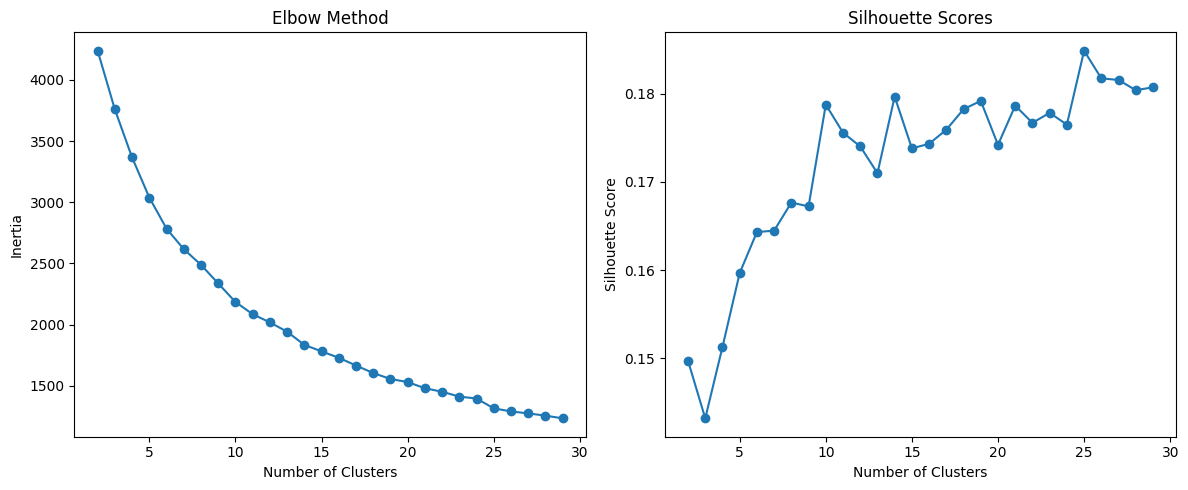

In [4]:
# 2. Determine Optimal Number of Clusters
# ---------------------------------------
# Use the Elbow Method and Silhouette Score
inertia = []
silhouette = []
cluster_range = range(2, 30)  # testing cluster sizes from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(df_scaled, labels)
    silhouette.append(silhouette_avg)

# Plot the Elbow Method and Silhouette Score side-by-side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.show()

In [5]:
# From the plots, assume the optimal number of clusters is 13
optimal_clusters = 26

In [6]:
# 3. Apply K-Means Clustering
# ---------------------------
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

In [7]:
# 4. Summarize Cluster Characteristics
# --------------------------------------
# Calculate average values for Pollution, CO2, and Temp for each cluster
cluster_summary = df.groupby('Cluster')[['Pollution', 'CO2', 'Temp']].mean().reset_index()
print("Cluster Summary (Average Values):")
print(cluster_summary)

Cluster Summary (Average Values):
    Cluster   Pollution         CO2       Temp
0         0  393.641026  375.000000  34.200716
1         1  349.000000  403.944444  72.673847
2         2  105.043478  347.543478  28.986317
3         3  383.423077  455.653846  35.770490
4         4  109.115385  427.807692  86.286554
5         5  124.666667  466.055556  80.134936
6         6  393.466667  335.377778  80.206085
7         7  130.861111  467.388889  73.292533
8         8  352.486486  344.702703  80.765046
9         9  371.953488  345.558140  40.021515
10       10  123.414634  431.341463  34.432784
11       11  223.285714  351.742857  29.341406
12       12  146.937500  459.312500  37.981145
13       13  176.256410  331.692308  73.649499
14       14   77.742857  406.571429  73.994334
15       15  332.806452  441.000000  72.243132
16       16  160.288889  353.600000  79.163260
17       17  377.280000  436.340000  80.163801
18       18   99.906977  383.674419  78.652581
19       19  382.029412  4

In [8]:
# 5. Label Clusters Based on Pollution Severity
# ----------------------------------------------
# For simplicity, sort clusters by average Pollution level and assign labels accordingly
sorted_clusters = cluster_summary.sort_values('Pollution')['Cluster'].values
severity_labels = {sorted_clusters[0]: 'Low Pollution',
                   sorted_clusters[1]: 'Moderate Pollution',
                   sorted_clusters[2]: 'High Pollution'}

# Map the labels to the main DataFrame
df['Pollution_Severity'] = df['Cluster'].map(severity_labels)

# Create a new dataset with City, Cluster, and Pollution_Severity (remove duplicates if cities appear multiple times)
new_dataset = df[['City', 'Cluster', 'Pollution_Severity']].drop_duplicates().reset_index(drop=True)
print("\nNew Dataset with Cluster Assignments and Pollution Severity:")
print(new_dataset.head())


New Dataset with Cluster Assignments and Pollution Severity:
            City  Cluster Pollution_Severity
0       Colorado        2                NaN
1    Mississippi        5                NaN
2    Mississippi       23                NaN
3        Arizona       18     High Pollution
4  New Hampshire       15                NaN


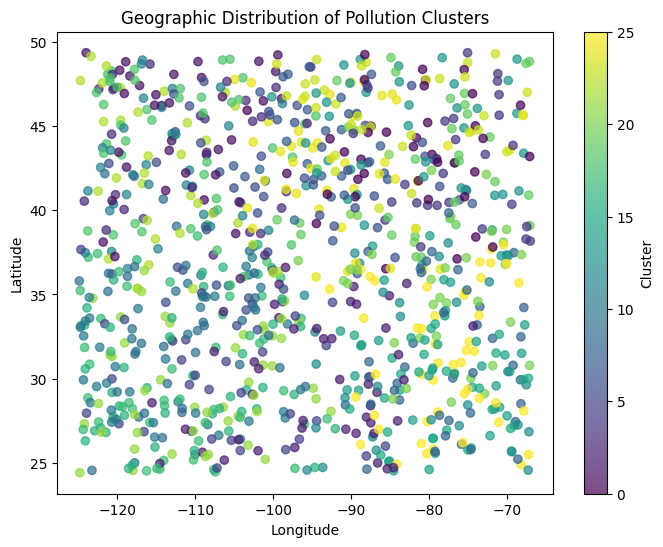

In [9]:
# 6. Visualize the Clusters
# -------------------------
# (a) Scatter plot of Longitude vs. Latitude colored by cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Pollution Clusters')
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
plt.show()

/tmp/ipykernel_147599/155453046.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Pollution Severity')


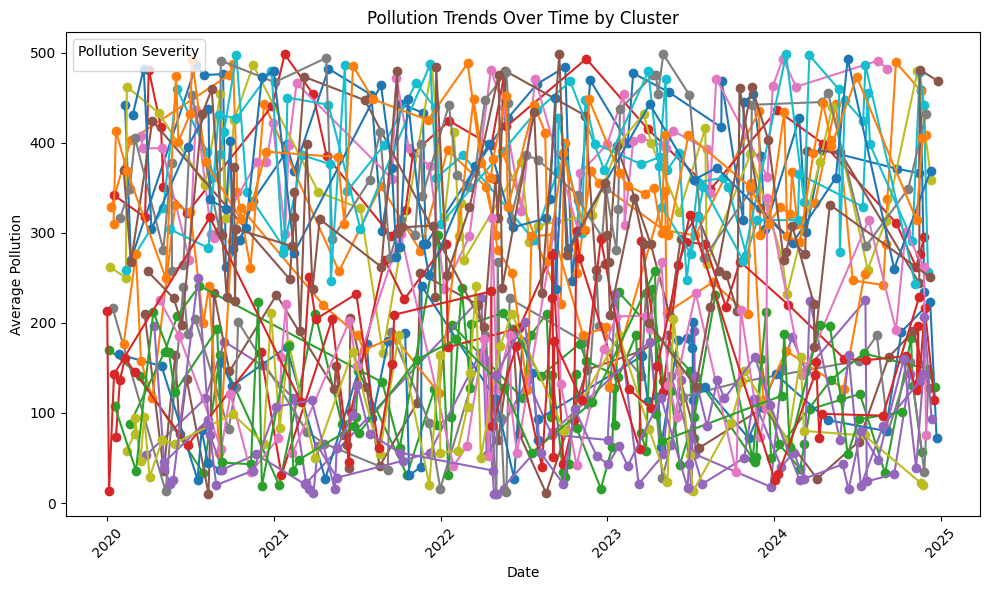

In [10]:
# (b) Pollution trends over time by cluster
# Group data by Date and Cluster to compute the average Pollution per day per cluster
pollution_trend = df.groupby(['Date', 'Cluster'])['Pollution'].mean().reset_index()

plt.figure(figsize=(10, 6))
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = pollution_trend[pollution_trend['Cluster'] == cluster]
    plt.plot(cluster_data['Date'], cluster_data['Pollution'], marker='o')
plt.xlabel('Date')
plt.ylabel('Average Pollution')
plt.title('Pollution Trends Over Time by Cluster')
plt.legend(title='Pollution Severity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# --- Data Preparation ---
# Ensure that the Date column is in datetime format and sort data by City and Date.
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['City', 'Date'])

In [12]:
# Calculate Temperature Change per city.
# Here, for a given record (year t), we define:
#    Temp_Change = (Average temperature for years t-3, t-2, t-1) - (Temperature for year t-4)
# We compute the rolling average with a window of 3 and shift by 1 so that the current year is not included.
df['temp_rolling'] = df.groupby('City')['Temp'].transform(lambda x: x.rolling(window=3).mean().shift(1))
df['temp_prev'] = df.groupby('City')['Temp'].shift(4)
df['Temp_Change'] = df['temp_rolling'] - df['temp_prev']

In [13]:
# --- Correlation Analysis ---
# 1. Temperature vs. Latitude
mask_temp_lat = df[['Temp', 'Latitude']].dropna()
corr_temp_lat, p_val_temp_lat = pearsonr(mask_temp_lat['Temp'], mask_temp_lat['Latitude'])

In [14]:
# 2. Temperature vs. Pollution
mask_temp_poll = df[['Temp', 'Pollution']].dropna()
corr_temp_poll, p_val_temp_poll = pearsonr(mask_temp_poll['Temp'], mask_temp_poll['Pollution'])

In [15]:
# 3. Temperature Change vs. Pollution
mask_temp_change_poll = df[['Temp_Change', 'Pollution']].dropna()
corr_temp_change_poll, p_val_temp_change_poll = pearsonr(mask_temp_change_poll['Temp_Change'], mask_temp_change_poll['Pollution'])

In [16]:
# Create a summary table with correlation coefficients and p-values.
results = pd.DataFrame({
    'Variable Pair': ['Temp vs. Latitude', 'Temp vs. Pollution', 'Temp_Change vs. Pollution'],
    'Pearson Correlation': [corr_temp_lat, corr_temp_poll, corr_temp_change_poll],
    'p-value': [p_val_temp_lat, p_val_temp_poll, p_val_temp_change_poll]
})

print("Correlation Analysis Results:")
print(results)

Correlation Analysis Results:
               Variable Pair  Pearson Correlation   p-value
0          Temp vs. Latitude             0.016918  0.593083
1         Temp vs. Pollution             0.004297  0.892054
2  Temp_Change vs. Pollution            -0.026674  0.451210


In [17]:
# --- Visualization ---
# Define a function to generate scatter plots with regression lines.
def scatter_with_regression(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, alpha=0.7)
    # Compute the regression line parameters.
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = intercept + slope * x_line
    plt.plot(x_line, y_line, color='red', label=f'Regression line (r = {r_value:.2f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

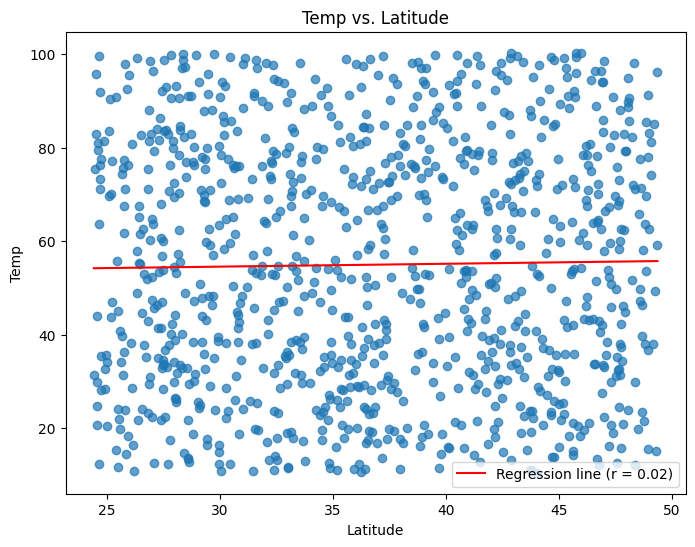

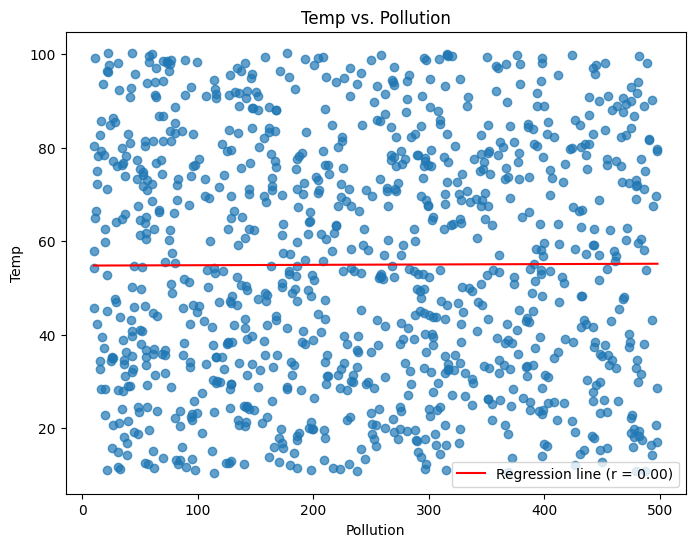

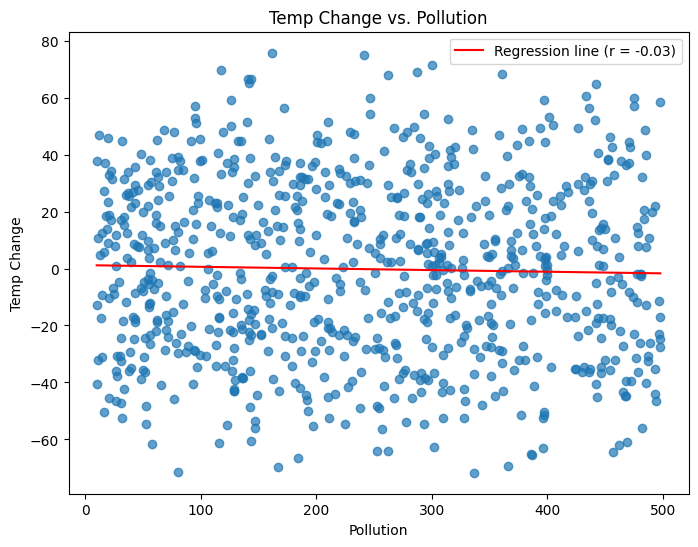

In [18]:
# Plot 1: Temperature vs. Latitude
scatter_with_regression(
    x=mask_temp_lat['Latitude'],
    y=mask_temp_lat['Temp'],
    xlabel='Latitude',
    ylabel='Temp',
    title='Temp vs. Latitude'
)

# Plot 2: Temperature vs. Pollution
scatter_with_regression(
    x=mask_temp_poll['Pollution'],
    y=mask_temp_poll['Temp'],
    xlabel='Pollution',
    ylabel='Temp',
    title='Temp vs. Pollution'
)

# Plot 3: Temperature Change vs. Pollution
scatter_with_regression(
    x=mask_temp_change_poll['Pollution'],
    y=mask_temp_change_poll['Temp_Change'],
    xlabel='Pollution',
    ylabel='Temp Change',
    title='Temp Change vs. Pollution'
)

## SECTION 2: Correlation Analysis

##SECTION 3: ARIMA model for temperature forecasting

In [ ]:
# Although we can determine p, q values manually by looking at the ACF and PACF plots for a given city, we must automate the process
#(OPTIONAL) To automate the process, we must perform a grid search over different values of p and q and choose the ARIMA model for which the AIC and BIC values are minimum

p_range = q_range = list(range(0,#))  # taking values from 0 to # (decide this looking at PACF)

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(city_df, order=(p, d, q))
            results = model.fit(disp=-1)
            aic_values.append(ARMAResults.aic(results))
            bic_values.append(ARMAResults.bic(results))
            pq_values.append((p, q))
        except:
            pass

best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)

In [ ]:
# fitting an ARIMA model with chosen p, d, q values and calculating the mean squared error
from sklearn.metrics import mean_absolute_error

arima_model = ARIMA(city_df, order=(best_pq[0], 0, best_pq[1])).fit()
predictions = arima_model.predict(start=0, end=len(city_df)-1)



## Conclusion

write here the report for the project